Deep Transformer Models for Time Series Forecasting: The Influenza Prevalence Case

http://arxiv.org/abs/2001.08317v1

https://blog.brainpad.co.jp/entry/2021/02/17/140000




この記事の注意事項として。
- 個人での勉強が目的であり、論文のモデルの再現度は高くありません
- 本文についてはGoogle翻訳を基にしていますので、不自然な文章となっている部分があります
(ただし、ほとんどの部分でGoogle翻訳の方が私より上手です。)
- コードは非常に見づらいですがご了承ください

業務で時系列データを扱うことがあるので、transformerを使った時系列予測モデルの勉強をしていきたいと思います。
あまり参考にできるwebページなどがありませんでしたが、モデルの中身自体は通常のtransformerと変わらないと読み取りましたので、とりあえず動くものを実装しました。

以下の論文です。
モデル自身に名前がついていないようなのであまりメジャーなものではないかもしれません。
もしくは、単にtransformerを時系列データに当てはめただけなので名前を付けなかったのかもしれません。

トランスフォーマーをベースとした時系列モデルの開発



### モデル
#### 問題設定
教師あり機械学習タスクとして ILI予測を定式化します。
N個の週次のデータ点$x_{t−N+1},\cdots,x_{t−1},x_t$を考えると、$M$ステップ先の予測では、教師ありMLモデルの入力$X$は$x_{t−N+1},\cdots,x_{t−M}$、出力$Y$は$x_{t−M+1},x_{t−M+2},\cdots,x_t$です。
各データ点$x_t$は、複数の特徴を含むスカラーまたはベクトルとして考えることができます。

#### Transformerモデル
今回のモデルはオリジナルのTransformerモデルに従い、Encoder・Decoderで構成されます。

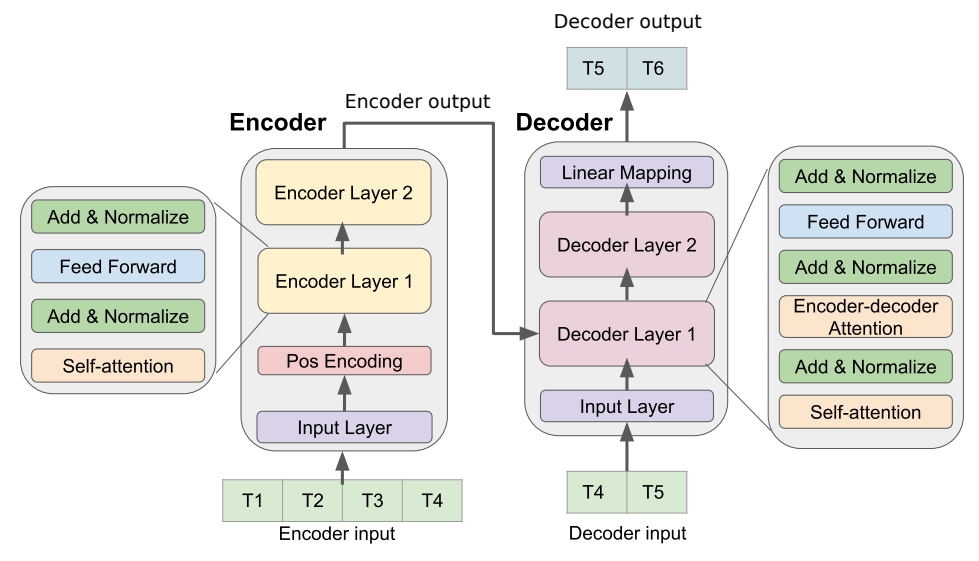

##### Encoder
Encoderは、input layer、positional encoding layer(PE layer)、および4つの同一のencoder layerの積み重ねで構成されます。
input layerでは、全結合ネットワークにより入力時系列データを次元$d_{model}$のベクトルにマッピングします。
サイン関数とコサイン関数を使用したPEは、入力ベクトルとPEベクトルを要素ごとに加算することによって、時系列データに位置情報を付与するために使用されます。
PE layerから出力されたベクトルは、4つのencoder layerに入力されます。
各encoder layerは、self-attention sub-layerと全結合のfeed-forward sub-layerの2つのsub-layerで構成されます。
各sub-layerの後には、normalization layerが続きます。
encoderは、$d_{model}$次元のベクトルを生成して、decoderに供給します。

##### Decoder
Decoderも、input layer、4つの同一のDecoder layer、およびoutput layerで構成されます。
Decoderの入力は、Encoderの入力の最後のデータ点から始まります。
input layerは、Decoderの入力を $d_{model}$次元のベクトルにマッピングします。
Decoderは各Encoder layerの2つのsub-layerに加えて3番目のsub-layerを挿入して、Encoderの出力にself-attentionを適用します。
最後に、decoder layerの出力をターゲットの時系列にマッピングするoutput layerがあります。
時系列データ点の予測が以前のデータ点のみに依存させるため、look-ahead maskingと、Decoderの入力とターゲット出力の間のone-position offsetを採用しています。

##### Time Delay Embedding
スカラー時系列データ$x_t$の場合、その時間遅延埋め込み(TDE)は、各$x_t$を$d$次元の時間遅延空間に埋め込むことによって形成されます。
$$
TDE_{d,\tau}(x_t)=(x_t,x_{t−\tau}, \cdots, x_{t−(d−1)\tau})
$$

通常の時系列予測のようにスライド窓でデータを切り取っていくことがTDEとなるので、今回は入力前に処理をしてEmbedding層は入れないこととにします。

#### データ
インフルエンザの患者数データを使用
Cdc fluview dashboard. https://gis.cdc.gov/grasp/fluview/fluportaldas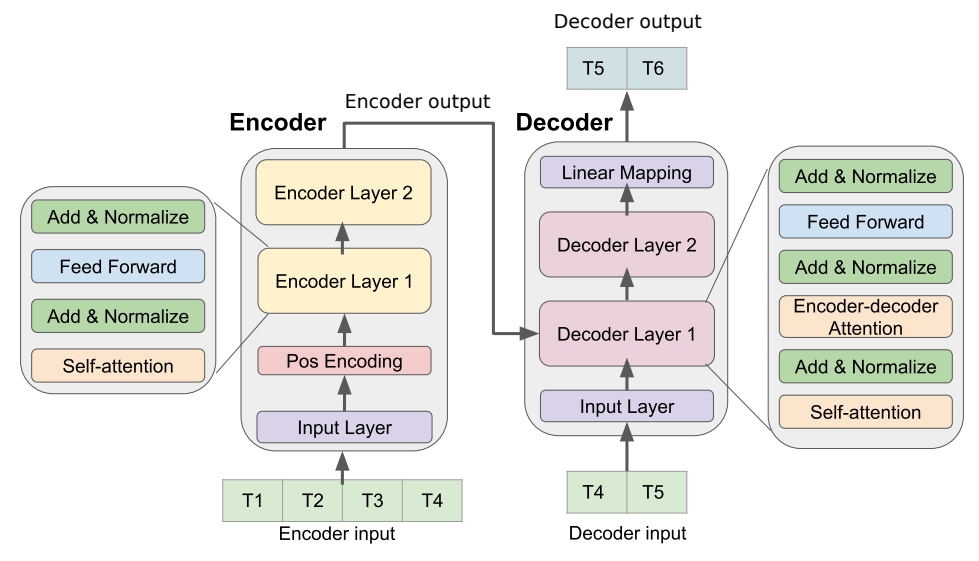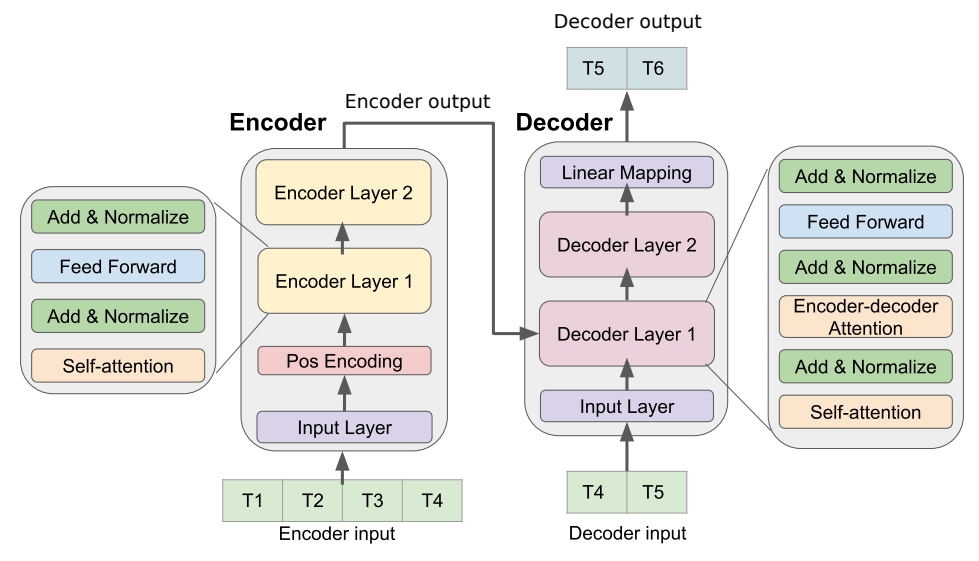hboard.html.
訓練用とテスト用に分けて使用。2020年以降は新型コロナの影響で傾向が大きく変わっているので2020年までのデータを使用。
前処理としてMinMaxスケーリングを行う。


#### トレーニング
10個(週)のデータ点から4点(週)先のILI比率を予測します。
encoder入力$(x_1, x_2, \cdots, x_{10})$とdecoder入力$(x_{10},\cdots,x_{13})$が与えられたときに、decoderは$(x_{11},\cdots,x_{14})$を出力するようにします。
look-ahead maskingを適用して、モデルが予測対象より前のデータ点にのみattentionを適用するようにします。
つまり、$(x_{11}, x_{12})$を予測するとき、マスクはDecoderが$x_{12}$と$x_{13}$の情報を漏らさないように、attention weightを$(x_{10}, x_{11})$のみに置きます。
トレーニングに使用するのはサイズ64のミニバッチとします。

#### Optimizer
最適化関数としてはAdamを使用し、$\beta_1=0.9,\beta_2=0.98,\epsilon=10^{-9}$とします。
学習率は、以下のスケジュールに従うものとします。
$$
lrate=d_{model}^{0.5}*\min(step\_num^{0.5},step\_num*warmup\_step^{-1.5})
$$
ここで、$warmup\_steps=5000$とします。

#### Regularization
encoderとdecoderの3つのsub-layer(self-attention,feed-forward,normalization)にdropoutを適用します。dropout rateは0.2とします。

#### Evaluation
ピアソンの相関係数とRMSEを計算します。

#### 実装
#### keras

transformerの分類モデルから変わった部分は、
- Embedding処理を省略(Time Delay Embeddingは前処理として事前に行う)
- 文章データと違い系列長が一定でpadding処理がないため、マスク処理はDecoderの未来の情報を隠す部分でのみ行う

です。実装内容については以前のものをほぼそのまま使用しているので、コードの内容は説明しません。

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Activation, Dropout, LayerNormalization, Reshape, Embedding, MultiHeadAttention
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt

In [2]:
class AddPositionalEncoding(Layer):
    '''
    入力テンソルに対し、位置の情報を付与して返すレイヤー
    see: https://arxiv.org/pdf/1706.03762.pdf

    PE_{pos, 2i}   = sin(pos / 10000^{2i / d_model})
    PE_{pos, 2i+1} = cos(pos / 10000^{2i / d_model})
    '''
    def call(self, inputs):
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

        # cos(x) == sin(x + π/2)
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

        pos_counter = tf.range(max_length)
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        # [batch_size, max_length, depth]
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

        return inputs + positional_encoding

In [3]:
class MultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        '''
        Multi-Head Attentionレイヤ
    
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : マルチヘッドAttentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''

        super(MultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
                   decoder:mask multihead attentionではq_length=m_length
                           2つ目のmultihead attentionではq_length≠m_length
        attention_mask : attention weight に適用される mask
            encoder : [1, 1, q_length, q_length]
            decoder : [1, 1, m_length, m_length]
        """
        # 各値を取得
        shape = query.shape.as_list() # batch_size, head_num, q_length, hidden_dim//head_num
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数(q_length)
        hidden_dim = shape[1]*shape[3] # 特徴ベクトルの長さ(head_num × hidden_dim//head_num = hidden_dim)
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [batch_size, head_num, q_length, hidden_dim/head_num] @ [batch_size, head_num, hidden_dim/head_num, m_length] = [batch_size, head_num, q_length, m_length]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [1, 1, (q|m)_length, (q|m)_length] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores, axis=-1)
        
        # 重みに従って value から情報を引いてきます
        # [batch_size, head_num, q_length, m_length] @ [batch_size, head_num, m_length, hidden_dim/head_num] = [batch_size, head_num, q_length, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = tf.transpose(context, [0, 2, 1, 3])
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim]
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, (q|m)_length, head_num, hidden_dim/head_num] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, (q|m)_length, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, (q|m)_length, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, q_length, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

In [4]:
class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        '''
        hidden_dim : Embeddingされた単語ベクトルの長さ
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='relu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        x : 入力 [batch_size, length, hidden_dim]
        '''
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, (q|m)_length, 4*hidden_dim] -> [batch_size, (q|m)_length, hidden_dim]
        return self.output_dense_layer(x)

In [5]:
class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        '''
        layer : 残渣接続したいレイヤ(MultiHeadAttentionかFeedForwardNetwork)に適用
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        モデルの実行
        
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのlengthと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            # attention weightを返す
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            # attention weightを返さない
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

In [6]:
class EncoderLayer(Layer):
    """
    Encoderレイヤ
    　MultiHeadAttentionとFeedForwardNetworkの組み合わせ
      それぞれ残差接続されている
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # Multi-head attention
        self.atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim,
                                       heads_num = heads_num,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # Feed Forward Network
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

In [7]:
class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, q_length, hidden_dim]
        memory: 入力 [batch_size, m_length, hidden_dim]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, q_length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)

        # Encoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

In [8]:
class DecoderLayer(Layer):
    """
    3つのsub-layerを持つ
    decoder layer : before ->[mask attention -> enc attention -> FF]-> next
    mask attentionは未来の情報を参照しないためのマスクを適用
    enc attentionはencoderの出力をkey, valueとする。
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # mask self-attention : mask処理を行う
        self.mask_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # attention : encoderの出力をmemory(key,value)として受け取る
        self.enc_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        if return_attention_scores:
            x, dec_attn_weights = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=return_attention_scores)
            x, encdec_attn_weights = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=return_attention_scores)
            x = self.ffn(x)
            return x, dec_attn_weights, encdec_attn_weights
        else:
            x = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=False)
            x = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=False)
            x = self.ffn(x)
            return x

In [9]:
class Decoder(Layer):
    '''
    TransformerのDecoder
    '''
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [DecoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        # Decoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, dec_attn_weights, encdec_attn_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)
            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), dec_attn_weights, encdec_attn_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

In [10]:
class TransformerBaseTimeSeriesForecastModel(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.encoder = Encoder(hopping_num, heads_num, hidden_dim, drop_rate)
        self.decoder = Decoder(hopping_num, heads_num, hidden_dim, drop_rate)
        
        # 全結合層
        self.fc = Dense(8)
        self.dropout = Dropout(drop_rate)
        self.final_layer = Dense(1)

    def call(self, inputs, training, return_attention_scores=False):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        enc_input, dec_input = inputs
        
        self_attention_mask=self._create_look_ahead_mask(dec_input)
        
        # Encoderの出力はDecoderへの入力(memory)となる
        # enc_input : [batch_size, enc_length, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        
        # dec_input : [batch_size, dec_length, hidden_dim]
        # dec_output : [batch_size, dec_length, hidden_dim]
        # dec_attn_weights : [batch_size, dec_length, dec_length]
        # encdec_attn_weights : [batch_size, dec_length, enc_length]
        if return_attention_scores:
            dec_output, dec_attn_weights, encdec_attn_weights = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
        else:
            dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
       
        
        # [batch_size, dec_length, hidden_dim] -> [batch_size, dec_length]
        fc_output = self.fc(dec_output)
        fc_output = self.dropout(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights, dec_attn_weights, encdec_attn_weights
        else:
            return final_output
    
    def _create_look_ahead_mask(self, x):
        batch_size, length, _ = x.shape
        autoregression_array = tf.logical_not(tf.linalg.band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
        autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])
        return tf.cast(autoregression_array, dtype=tf.float32)

In [11]:
class minmaxscaling:
    def __init__(self,max_value, min_value, upl=0, downl=0):
        self.max = max_value + max_value*upl
        self.min = min_value - min_value*downl
    
    def translate(self, x):
        return (x - self.min) / (self.max - self.min)

def make_ts_data(window_width, dmodel, pred_points, split_point):
    data = pd.read_csv('ilidata.csv')
    data = np.array(data[['WEIGHTED_ILI']])

    scaler = minmaxscaling(8, 0, 0.1)
    data = scaler.translate(data).ravel()

    train_data = data[:split_point]
    test_data = data[split_point-dmodel:570]

    train_emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])
    test_emb_data = np.array([test_data[i:i+dmodel] for i in range(len(test_data)-dmodel)])

    enc_train = np.array([train_emb_data[i:i+window_width] for i in range(len(train_emb_data)-window_width-pred_points)])
    dec_train = np.array([train_emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(train_emb_data)-window_width-pred_points)])
    y_train = np.array([train_emb_data[i+window_width:i+window_width+pred_points] for i in range(len(train_emb_data)-window_width-pred_points)])

    enc_test = np.array([test_emb_data[i:i+window_width] for i in range(len(test_emb_data)-window_width-pred_points)])
    dec_test = np.array([test_emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(test_emb_data)-window_width-pred_points)])
    y_test = np.array([test_emb_data[i+window_width:i+window_width+pred_points] for i in range(len(test_emb_data)-window_width-pred_points)])

    enc_train = tf.constant(enc_train)
    enc_test = tf.constant(enc_test)
    dec_train = tf.constant(dec_train)
    dec_test = tf.constant(dec_test)
    y_train = tf.constant(y_train)
    y_test = tf.constant(y_test)

    print('encinput_train ', enc_train.shape)
    print('decinput_train ', dec_train.shape)
    print('y_train ', y_train.shape)

    print('encinput_test ', enc_test.shape)
    print('decinput_test ', dec_test.shape)
    print('y_test ', y_test.shape)
    return enc_train, dec_train, y_train, enc_test, dec_test, y_test

window_width = 10 # 予測に使う点数
dmodel = 8 # embeddingの次元
pred_points = 4 # 予測する点数
split_point = 515 # trainとtestを分ける点
enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

encinput_train  (493, 10, 8)
decinput_train  (493, 4, 8)
y_train  (493, 4, 8)
encinput_test  (41, 10, 8)
decinput_test  (41, 4, 8)
y_test  (41, 4, 8)


In [12]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model = TransformerBaseTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=1, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [13]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=100, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/100
62/62 - 11s - loss: 1.3473 - mse: 1.3473 - lr: 0.0000e+00 - 11s/epoch - 181ms/step
Epoch 2/100
62/62 - 1s - loss: 1.2952 - mse: 1.2952 - lr: 8.0000e-06 - 635ms/epoch - 10ms/step
Epoch 3/100
62/62 - 1s - loss: 1.2311 - mse: 1.2311 - lr: 1.6000e-05 - 668ms/epoch - 11ms/step
Epoch 4/100
62/62 - 1s - loss: 1.2211 - mse: 1.2211 - lr: 2.4000e-05 - 734ms/epoch - 12ms/step
Epoch 5/100
62/62 - 1s - loss: 1.0855 - mse: 1.0855 - lr: 3.2000e-05 - 714ms/epoch - 12ms/step
Epoch 6/100
62/62 - 1s - loss: 0.9939 - mse: 0.9939 - lr: 4.0000e-05 - 684ms/epoch - 11ms/step
Epoch 7/100
62/62 - 1s - loss: 0.8598 - mse: 0.8598 - lr: 4.8000e-05 - 645ms/epoch - 10ms/step
Epoch 8/100
62/62 - 1s - loss: 0.7825 - mse: 0.7825 - lr: 5.6000e-05 - 674ms/epoch - 11ms/step
Epoch 9/100
62/62 - 1s - loss: 0.6734 - mse: 0.6734 - lr: 6.4000e-05 - 653ms/epoch - 11ms/step
Epoch 10/100
62/62 - 1s - loss: 0.5932 - mse: 0.5932 - lr: 7.2000e-05 - 657ms/epoch - 11ms/step
Epoch 11/100
62/62 - 1s - loss: 0.4334 - mse: 0.4

In [14]:
#model.save('transformer_ts_predict')

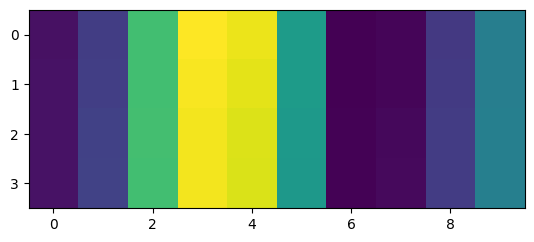

In [15]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [16]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,4,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(4):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

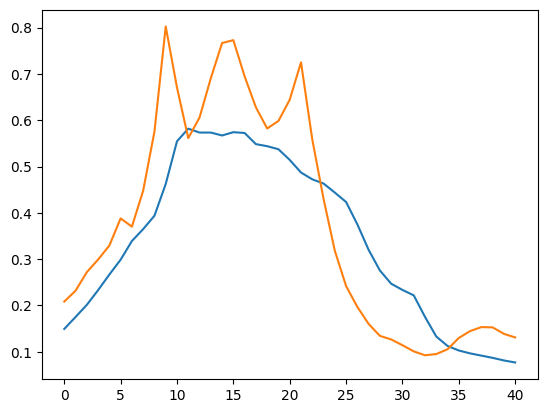

In [17]:
plt.plot(pred_results[:,0,0,0])
plt.plot(y_test[:,0,-1]);

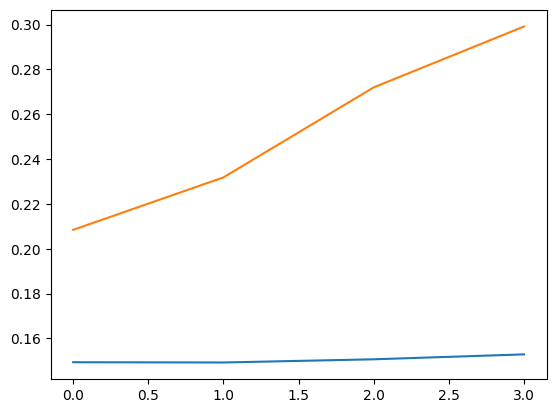

In [18]:
plt.plot(pred_results[0,0,:])
plt.plot(y_test[0,:,-1]);

In [19]:
window_width = 10
dmodel = 16
pred_points = 8

enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

encinput_train  (481, 10, 16)
decinput_train  (481, 8, 16)
y_train  (481, 8, 16)
encinput_test  (37, 10, 16)
decinput_test  (37, 8, 16)
y_test  (37, 8, 16)


In [21]:
model = TransformerBaseTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [22]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
61/61 - 11s - loss: 0.8264 - mse: 0.8264 - lr: 0.0000e+00 - 11s/epoch - 176ms/step
Epoch 2/200
61/61 - 1s - loss: 0.7907 - mse: 0.7907 - lr: 1.1314e-05 - 858ms/epoch - 14ms/step
Epoch 3/200
61/61 - 1s - loss: 0.7571 - mse: 0.7571 - lr: 2.2627e-05 - 859ms/epoch - 14ms/step
Epoch 4/200
61/61 - 1s - loss: 0.6539 - mse: 0.6539 - lr: 3.3941e-05 - 914ms/epoch - 15ms/step
Epoch 5/200
61/61 - 1s - loss: 0.5661 - mse: 0.5661 - lr: 4.5255e-05 - 925ms/epoch - 15ms/step
Epoch 6/200
61/61 - 1s - loss: 0.4635 - mse: 0.4635 - lr: 5.6569e-05 - 873ms/epoch - 14ms/step
Epoch 7/200
61/61 - 1s - loss: 0.3784 - mse: 0.3784 - lr: 6.7882e-05 - 927ms/epoch - 15ms/step
Epoch 8/200
61/61 - 1s - loss: 0.3303 - mse: 0.3303 - lr: 7.9196e-05 - 908ms/epoch - 15ms/step
Epoch 9/200
61/61 - 1s - loss: 0.2660 - mse: 0.2660 - lr: 9.0510e-05 - 872ms/epoch - 14ms/step
Epoch 10/200
61/61 - 1s - loss: 0.2103 - mse: 0.2103 - lr: 1.0182e-04 - 938ms/epoch - 15ms/step
Epoch 11/200
61/61 - 1s - loss: 0.1797 - mse: 0.1

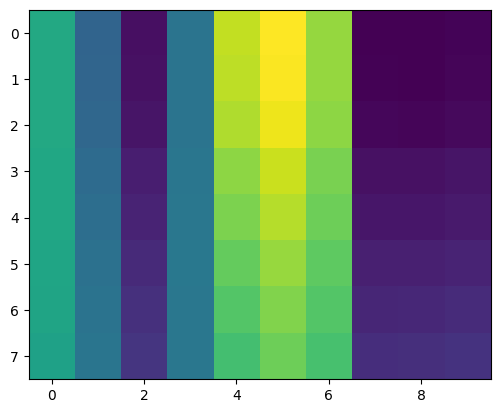

In [23]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [24]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

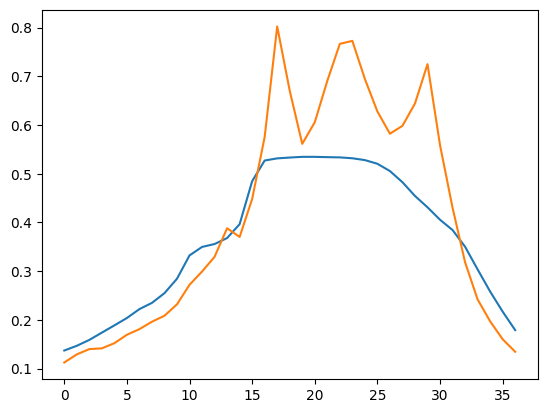

In [25]:
plt.plot(pred_results[:,0,0,0])
plt.plot(y_test[:,-1,0]);

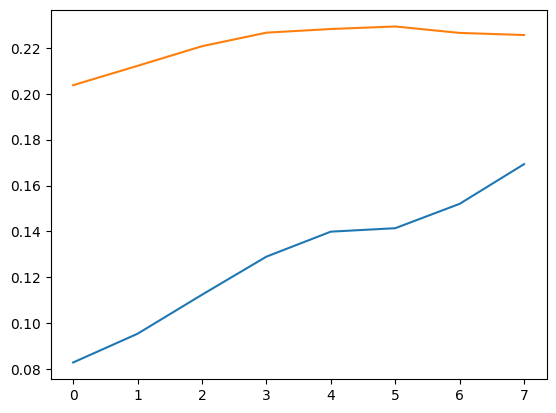

In [26]:
plt.plot(y_test[5,:,0]);
plt.plot(pred_results[5,0])

In [ ]:
window_width = 20
dmodel = 24
pred_points = 16

enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

In [ ]:
model = TransformerBaseTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=4, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [ ]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

In [ ]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [ ]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

In [ ]:
#plt.plot(pred_results[:,0,5,0])
plt.plot(y_test[5,:,0]);
plt.plot(pred_results[5,0])
#plt.xlim(0,20)
#plt.ylim(0,4)

In [ ]:
y_test.shape